In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.videotag import VIDEOtagGenerator
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import json
import skimage.io
from numpy import array

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())


args_input_json = '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/mrcnn_result_instances.json'
args_image_dir = '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/images'
args_image_log_dir = '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/logs/retinanet'
args_output_all_json = '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/retinanet_all_instances.json'
args_output_new_json = '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/retinanet_new_instances.json'
ROOT_DIR = os.getcwd()


os.makedirs(args_image_log_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Model

In [16]:
model = keras.models.load_model('/Users/luke/Documents/ml_models/deep/cate3/resnet50_csv_epoch_20_loss_0.88256.h5', custom_objects=custom_objects)

/Users/luke/.pyenv/versions/3.6.3/envs/py36/lib/python3.6/site-packages/keras/models.py:274: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  sample_weight_mode=sample_weight_mode)


# Set - deepfashion category

In [4]:
coco_class_names = ['upper-body', 'lower-body', 'full-body']

# Test - Detection (Single Image)

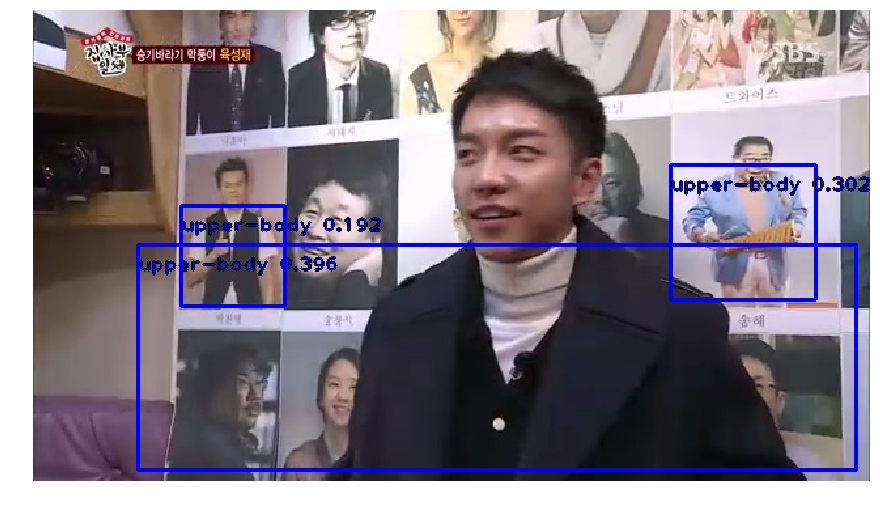

In [5]:
# img_path = '/Users/luke/Documents/ml_datasets/new/all/images/val2017/000000551820.jpg'
# img_path = '/Users/luke/Documents/dev/github/milkplz/keras-retinanet/dataset/deepfashion/images/100000000032.jpg'
img_path = '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/images/29296-65697590-ee3f-11e7-bbcd-afbd708e5bbe.jpg'
# img_path = '../dataset/deepfashion/images/100000021448.jpg'
image = read_image_bgr(img_path)#skimage.io.imread(img_path)

draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image, min_side=600, max_side=1024)

_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))

predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]


# correct for image scale
detections[0, :, :4] /= scale

found_num = 0
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.1:
        continue

    found_num += 1
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
    caption = "{} {:.3f}".format(coco_class_names[label], score)
    cv2.putText(draw, caption, (b[0], b[1] + 20), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(draw, caption, (b[0], b[1] + 20), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1)
    
if not found_num == 0:
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

# Load VIDEOtag Dataset Annotations

In [17]:
# NOTE : VIDEOtag Data (검색용)

id_annotations = {}
imageid_annotationids = {}

vt_anno_ary = []
vt_img_ary = []
vt_cate_ary = []

def loadJson(path):
    json_data = open(path).read()
    data = json.loads(json_data)

    # NOTE : VIDEOtag Data (원본)
    anno_ary = data['annotations']
    img_ary = data['images']
    cate_ary = data['categories']
    
    id_annos = {}
    imgid_annoids = {}
    
    for anno in anno_ary:
        id_annos[anno['id']] = anno

    for image in img_ary:
        anno_ids = []
        image_id = image['id']

        for anno in anno_ary:
            anno_img_id = anno['image_id']
            anno_id = anno['id']
            if anno_img_id == image_id:
                anno_ids.append(anno_id)

        imgid_annoids[image_id] = anno_ids
        
    return anno_ary, img_ary, cate_ary, id_annos, imgid_annoids
        

def get_annos(img_id):
    anno_ids = imageid_annotationids[img_id]
    annos = []
    for anno_id in anno_ids:  
        annos.append(id_annotations[anno_id])

    return annos

def bbox_to_anno(anno_id, bbox):
    if anno_id in id_annotations:
        anno = id_annotations[anno_id]
        anno['bbox'] = bbox
        return anno
    else:
        return null
#     for anno in vt_anno_ary:
#         if anno['id'] == anno_id:
#             anno['bbox'] = bbox
#             return anno
#             break
            
def load_image(path):
    image = read_image_bgr(path)
    img_height, img_width = image.shape[:2]
    return image, img_height, img_width

def processing_image(image):
    image = preprocess_image(image)
    image, scale = resize_image(image, min_side=600, max_side=1024)
    return image, scale

def copy_anno(anno):
    new_anno = {}
    new_anno['bbox'] = anno['bbox']
    new_anno['category_id'] = anno['category_id']
    new_anno['id'] = anno['id']
    new_anno['image_id'] = anno['image_id']
    new_anno['iscrowd'] = anno['iscrowd']
    new_anno['area'] = anno['area']
    new_anno['segmentation'] = anno['segmentation']
    return new_anno

# def upate_anno(anno_id, cate_id, bbox, segmentation):
#     for anno in vt_anno_ary:
#         if anno['id'] == anno_id:
#             if not 'sub_category_id' in anno:
#                 anno['bbox'] = bbox
#                 anno['segmentation'] = segmentation
#                 anno['sub_category_id'] = cate_id
#                 return anno
#             else:
#                 new_anno = copy_anno(anno)
#                 new_anno['id'] = str(anno['category_id'])+'_'+str(cate_id)
#                 vt_anno_ary.append(new_anno)
#                 return new_anno
#             break
            
def create_anno(anno_id, cate_id, bbox, segmentation, point_x, point_y):
    for anno in vt_anno_ary:
        if anno['id'] == anno_id:
            new_anno = copy_anno(anno)
            new_anno['id'] = str(anno['id'])+'_'+str(anno['category_id'])+'_'+str(cate_id)
            new_anno['bbox'] = bbox
            new_anno['category_id'] = str(cate_id)
            new_anno['segmentation'] = segmentation    
            new_anno['x_pos'] = point_x
            new_anno['y_pos'] = point_y
            vt_anno_ary.append(new_anno)
            return new_anno   
            break
            
vt_anno_ary, vt_img_ary, vt_cate_ary, id_annotations, imageid_annotationids = loadJson(args_input_json)

print(len(vt_img_ary))
print('complete load_json')

1081
complete load_json


## Test

In [10]:
ANNO_NEW_ID_COUNT = 0

new_anno = {}
new_anno['id'] = 123
new_anno['bbox'] = [0,0,0,0]
new_anno['category_id'] = 1
new_anno['image_id'] = '1234'
new_anno['iscrowd'] = 0
new_anno['area'] = 1
new_anno['segmentation'] = [0,1,2,3,4,5,6,7]

print(copy_anno(new_anno))



{'bbox': [0, 0, 0, 0], 'category_id': 1, 'id': 123, 'image_id': '1234', 'iscrowd': 0, 'area': 1, 'segmentation': [0, 1, 2, 3, 4, 5, 6, 7]}


# Mask 처리 로직

(36, 2)
(46, 200, 420, 153)


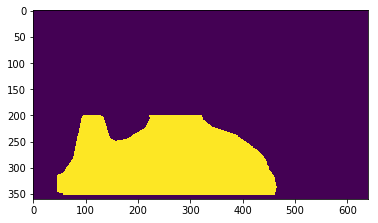

In [11]:
from operator import itemgetter, attrgetter, methodcaller
from skimage.measure import find_contours
from skimage.measure import approximate_polygon


def contours_to_mask(contours, height, width):
    contours = np.reshape(contours, (-1, 2)).astype(int)
    new_contours = contours.copy()
    new_contours[:,1] = contours[:,0]
    new_contours[:,0] = contours[:,1]

#     print(contours.shape)

    # extract mask (0,1과 이루어진 array)
    mask = np.zeros([height,width,1],dtype=np.uint8)
    mask.fill(0)
    cv2.drawContours(mask, [new_contours], 0, (1), -1)
    mask = np.reshape(mask, (height, width))
    
    return mask

def bbox_to_mask(bbox, height, width):
    mask = np.zeros([height, width, 1],dtype=np.uint8)
    mask.fill(0)
    cv2.rectangle(mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (1, 1, 1), -1)
    mask = np.reshape(mask, (height, width))
    return mask



def draw_box(image, box, color):
    """Draw 3-pixel width bounding boxes on the given image array.
    color: list of 3 int values for RGB.
    """
    y1, x1, y2, x2 = box
    image[y1:y1 + 2, x1:x2] = color
    image[y2:y2 + 2, x1:x2] = color
    image[y1:y2, x1:x1 + 2] = color
    image[y1:y2, x2:x2 + 2] = color
    return image

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def get_intersection_area(contours_mask, bbox_mask):
    intersection_area = contours_mask * bbox_mask
    return intersection_area
    
def mask_to_contours(mask):
    padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0)
    np_contours = np.array(contours)
    np_contours = np_contours[0]
    np_contours = approximate_polygon(np_contours, tolerance=2.5)
    np_contours = [np_contours.flatten().tolist()]
    return np_contours

# 정확도가 높은 순으로 return함
def find_intersection_area(annos, bbox, height, width):
    result = []
    for anno in annos:
        if 'segmentation' in anno:
            contours_mask = contours_to_mask(anno['segmentation'], height, width)
            bbox_mask = bbox_to_mask(bbox, height, width)
            result_mask = get_intersection_area(contours_mask, bbox_mask)
            area = result_mask.sum()
            min_area = (contours_mask.shape[0]*contours_mask.shape[1])*0.001
            if area > min_area:
                # point
                mu = cv2.moments(result_mask)
                point_x = (mu['m10']/mu['m00'])/width
                point_y = (mu['m01']/mu['m00'])/height
                # bbox
                result_bbox = cv2.boundingRect(result_mask)
                result.append([anno['id'], result_mask, result_bbox, area, [point_x, point_y]])
                
    return sorted(result, key=itemgetter(3), reverse=True)
            

# test
contours = [354.0, 460.0, 354.0, 58.0, 348.0, 57.0, 346.0, 46.0, 314.0, 46.0, 309.0, 58.0, 280.0, 77.0, 203.0, 93.0, 191.0, 100.0, 191.0, 117.0, 204.0, 134.0, 244.0, 147.0, 249.0, 158.0, 245.0, 179.0, 224.0, 214.0, 205.0, 223.0, 158.0, 205.0, 142.0, 203.0, 108.0, 214.0, 88.0, 216.0, 71.0, 236.0, 68.0, 272.0, 76.0, 299.0, 85.0, 308.0, 110.0, 321.0, 168.0, 324.0, 188.0, 317.0, 208.0, 324.0, 222.0, 342.0, 237.0, 387.0, 269.0, 431.0, 285.0, 445.0, 303.0, 450.0, 316.0, 460.0, 337.0, 465.0, 354.0, 460.0]
contours_mask = contours_to_mask(contours, 360, 640)

bbox = [46, 200, 539, 352]
bbox_mask = bbox_to_mask(bbox, 360, 640)

intersection_area = get_intersection_area(contours_mask, bbox_mask)

contours = array(contours)
contours = np.asarray(contours.reshape(-1,2))

print(contours.shape)
# x,y,w,h = cv2.boundingRect(contours)
# cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
# print(x,y,w,h)

rect = cv2.boundingRect(intersection_area)
print(rect)


# result_bbox = cv2.minAreaRect(contours)
# print(result_bbox)
cv2.rectangle(draw, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (0, 255, 0), 3)

plt.imshow(intersection_area)
plt.show()


## Test

1


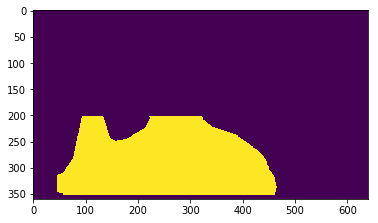

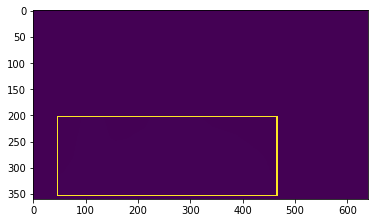

In [13]:
# 테스트

test_annos = [{'id': '297282', 'x_pos': 0.40505226480836237, 'y_pos': 0.1826625386996904, 'image_id': '199606', 'category_id': 'B08'}, {'id': '297283', 'x_pos': 0.6202090592334495, 'y_pos': 0.718266253869969, 'image_id': '199606', 'category_id': 'A09'}, {'bbox': [46, 50, 432, 303], 'category_id': '1', 'id': 'new_0', 'image_id': '199606', 'iscrowd': 0, 'area': 63499, 'segmentation': [[354.0, 460.0, 354.0, 58.0, 348.0, 57.0, 346.0, 46.0, 314.0, 46.0, 309.0, 58.0, 280.0, 77.0, 203.0, 93.0, 191.0, 100.0, 191.0, 117.0, 204.0, 134.0, 244.0, 147.0, 249.0, 158.0, 245.0, 179.0, 224.0, 214.0, 205.0, 223.0, 158.0, 205.0, 142.0, 203.0, 108.0, 214.0, 88.0, 216.0, 71.0, 236.0, 68.0, 272.0, 76.0, 299.0, 85.0, 308.0, 110.0, 321.0, 168.0, 324.0, 188.0, 317.0, 208.0, 324.0, 222.0, 342.0, 237.0, 387.0, 269.0, 431.0, 285.0, 445.0, 303.0, 450.0, 316.0, 460.0, 337.0, 465.0, 354.0, 460.0]], 'x_pos': 0.39602589706137103, 'y_pos': 0.7088430963917192}]
test_bbox = [46, 202, 539, 352]
test_label = 0
test_img_height = 360
test_img_width = 640

intersection_area_datas = find_intersection_area(test_annos, test_bbox, test_img_height, test_img_width)
print(len(intersection_area_datas))
if not len(intersection_area_datas) == 0:
    for area_data in intersection_area_datas:
        anno_id, mask, bbox, area, [point_x, point_y] = area_data
        # draw mask
        plt.imshow(mask)
        plt.show()
        # draw bbox
        cv2.rectangle(mask, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), (255, 0, 0), 2)
        plt.imshow(mask)
        plt.show()

## Test

(360, 640, 1)


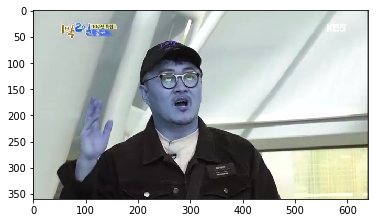

In [14]:
# 테스트

# array 출력 시 생략하지 않고, 모두 출력.
np.set_printoptions(threshold=np.nan)
            
mask_image = np.zeros([360,640,1],dtype=np.uint8)
mask_image.fill(0)
cv2.rectangle(mask_image, (100, 100), (200, 20), (1, 1, 1), -1)
print(mask_image.shape)
mask_image = np.reshape(mask_image, (360,640))

img_path = '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/images/29319-e39c4540-ee3b-11e7-bbcd-afbd708e5bbe.jpg'
image, img_height, img_width = load_image(img_path)

plt.imshow(image)
plt.show()


# Extract 교집합 영역

Mask R-CNN에서 검출된 category person - Mask Region과 keras-retinanet에서 검출되는 category(upper-body, lower-body, full-body) bbox영역의 교집합 영역을 추출합니다.

In [18]:
import imageio


np.set_printoptions(threshold=np.nan)

###################################################################
# 모든 이미지에 대하여 predict를 실시한다.
###################################################################
img_total = len(vt_img_ary)

new_annos = []

for img_idx, img_data in enumerate(vt_img_ary): 
    # NOTE : d_ -> detected_, a_ -> answer_
    
    print(str(img_idx)+'/'+str(img_total)+'/'+img_data['id'])
    
    if img_idx > 10:
        break
    
    a_vt_annos = get_annos(img_data['id'])
    if len(a_vt_annos) == 0:
        continue
    
    ###################################################################
    # videotag image 로드
    ###################################################################
    image, img_height, img_width = load_image(os.path.join(ROOT_DIR, args_image_dir, img_data['file_name']) )
    
    
#     # draw mrcnn-result
#     for v_anno in a_vt_annos:
#         if 'bbox' in v_anno:
#             v_anno_bbox = v_anno['bbox']
#             draw_copy = draw_box(image, [v_anno_bbox[1], v_anno_bbox[0], v_anno_bbox[1]+v_anno_bbox[3], v_anno_bbox[0]+v_anno_bbox[2]], [255,0,255])
#             cv2.putText(image, v_anno['category_id'], (v_anno_bbox[0], v_anno_bbox[1] + 20), cv2.FONT_HERSHEY_PLAIN, 1.0, (255,0,255), 2)
       
#     save_path = os.path.join(ROOT_DIR, args_image_log_dir, img_data['id']+'_'+str(img_idx)+'.jpg') 
#     imageio.imwrite(save_path, image)
#     continue
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image, scale = processing_image(image)
    
    ###################################################################
    # Run detection
    ###################################################################
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    
    # correct for image scale
    detections[0, :, :4] /= scale
    
    found_num = 0
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.2:
            continue
            
        draw_copy = draw.copy()
            
        found_num += 1
        d_bbox = detections[0, idx, :4].astype(int)
        
        # draw detection
        draw_copy = draw_box(draw_copy, [d_bbox[1], d_bbox[0], d_bbox[3], d_bbox[2]], [255,0,0])
        caption = "{} {:.3f}".format(coco_class_names[label], score) # deepfahsion
        cv2.putText(draw_copy, caption, (d_bbox[0], d_bbox[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), 2)
        cv2.putText(draw_copy, caption, (d_bbox[0], d_bbox[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.0, (255, 0, 0), 1)
        
        # draw mrcnn-result
        for v_anno in a_vt_annos:
            if 'bbox' in v_anno:
                v_anno_bbox = v_anno['bbox']
                draw_copy = draw_box(draw_copy, [v_anno_bbox[1], v_anno_bbox[0], v_anno_bbox[1]+v_anno_bbox[3], v_anno_bbox[0]+v_anno_bbox[2]], [255,0,255])
                cv2.putText(draw_copy, v_anno['category_id'], (v_anno_bbox[0], v_anno_bbox[1] + 20), cv2.FONT_HERSHEY_PLAIN, 1.0, (255,0,255), 2)
        
        intersection_area_datas = find_intersection_area(a_vt_annos, d_bbox, img_height, img_width)
        if not len(intersection_area_datas) == 0:
            for idx, area_data in enumerate(intersection_area_datas):
                anno_id, res_mask, res_bbox, area, [point_x, point_y] = area_data
                
                # draw intersection (mrcnn-retinanet)
                if idx == 0:
                    new_anno = create_anno(anno_id, label, res_bbox, mask_to_contours(res_mask), point_x, point_y)
                    new_annos.append(new_anno)
                    draw_copy = apply_mask(draw_copy, res_mask, (255,0,0), alpha=0.5)  
                    cv2.rectangle(draw_copy, (res_bbox[0], res_bbox[1]), (res_bbox[0]+res_bbox[2], res_bbox[1]+res_bbox[3]), (0, 255, 0), 3)
                else:
                    cv2.rectangle(draw_copy, (res_bbox[0], res_bbox[1]), (res_bbox[0]+res_bbox[2], res_bbox[1]+res_bbox[3]), (0, 255, 255), 1)
        else:
            print('not found intersection_area')
            
        save_path = os.path.join(ROOT_DIR, args_image_log_dir, img_data['id']+'_'+str(idx)+'.jpg') 
        imageio.imwrite(save_path, draw_copy)
            
#         plt.figure(figsize=(15, 15))
#         plt.axis('off')
#         plt.imshow(draw_copy)
#         plt.show()

print('done')

0/1081/199605
1/1081/199606
2/1081/199607
3/1081/199608
4/1081/199609
5/1081/199610
6/1081/199611
7/1081/199612
8/1081/199613
9/1081/199614
10/1081/199615
11/1081/199616
done


In [20]:
result_all = {}
result_all['annotations'] = vt_anno_ary
result_all['images'] = vt_img_ary
result_all['categories'] = vt_cate_ary

with open(args_output_all_json, 'w') as outfile:
    json.dump(result_all, outfile)
    
    
result_new = {}
result_new['annotations'] = new_annos
result_new['images'] = vt_img_ary
result_new['categories'] = vt_cate_ary

with open(args_output_new_json, 'w') as outfile:
    json.dump(result_new, outfile)
    
print('done')